In [244]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class SparseLoss(nn.Module):
    def __init__(self, model, base_loss, lambda_reg=0.01):
        super(SparseLoss, self).__init__()
        self.base_loss = base_loss
        self.lambda_reg = lambda_reg
        self.model = model


    def sparsify(self,x):    
        n = (t.abs(x) < 1) 
        l = t.zeros_like(x)
        l[n]  = - t.cos( 2 * t.pi * x[n] ) - 2.0*t.cos(  t.pi * x[n] ) 
        l[~n] = t.abs(x[~n]) *10.0 - 9.0


        # x = - t.cos( 2 * t.pi * x ) - 2.0*t.cos(  t.pi * x ) 

        return l
        

    def forward(self, output, target):
        loss = self.base_loss(output, target)
        
        # L1 regularization to promote sparsity
        l1_reg = t.vstack([ t.sum(self.sparsify(param)) for param in self.model.parameters()] ).sum()
        
        # Total loss is a combination of the base loss and the regularization term
        total_loss = loss + self.lambda_reg * l1_reg

        print(loss.item(),l1_reg.item())

        return total_loss


# Generate an array of values from -5 to 5
x_vals = t.linspace(-1.1, 1.1, 500)
# Compute the loss for each value in the array
criterion = SparseLoss(model, nn.MSELoss(), lambda_reg=1)
loss_vals = criterion.sparsify(x_vals)

# Plot the loss values
plt.figure(figsize=(10,6))
plt.plot(x_vals, loss_vals, label='Custom Loss')
plt.xlabel('Input Value')
plt.ylabel('Loss Value')
plt.title('Custom Loss for Various Input Values')
plt.grid(True)
plt.legend()
plt.show()


In [240]:


# Create a simple two-layer feedforward neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 11)  # First layer with 50 neurons
        self.fc2 = nn.Linear(11, 1)  # Second layer with 1 neuron (output layer)
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

        # self.fc1.weight.data = torch.tensor([[.9, -.4, 0.0,0.0,0.0]], dtype=torch.float32).T
        # self.fc2.weight.data.fill_(1.0)


    def forward(self, x):
        x = t.relu(self.fc1(x))  
        # x = self.fc1(x)
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = Net()
criterion = SparseLoss(model, nn.MSELoss(), lambda_reg=.01)
#criterion = nn.MSELoss()
#optimizer = optim.Adam([param for name, param in model.named_parameters() if 'bias' not in name], lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Generate some training data
x_train = t.linspace(-10, 10, 1000).view(-1, 1)
y_train = abs(x_train)# * x_train


# Train the model
steps = 5000
for epoch in range(steps):
    model.train()

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5000 == 0:
        print(f'Epoch [{epoch+1}/{steps}], Loss: {loss.item():.4f}')

# Plot the training data and model's predictions
model.eval()
predicted = model(x_train).detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), label='y = x*x')
plt.plot(x_train.numpy(), predicted, label='Predicted')
plt.title('y = x*x and Predicted values')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

params = [ t.sum(param.data).item() for name, param in model.named_parameters() ] 
print(t.sum(t.tensor(params)))


43.903167724609375 -59.102325439453125
40.74225616455078 -59.177249908447266
37.79783630371094 -59.14398956298828
35.068519592285156 -59.00382614135742
32.550506591796875 -58.761253356933594
30.23702621459961 -58.42292785644531
28.119340896606445 -57.994789123535156
26.188800811767578 -57.39243698120117
24.437620162963867 -56.705650329589844
22.85853385925293 -55.94858169555664
21.444589614868164 -55.1273193359375
20.188974380493164 -54.24858856201172
19.08482551574707 -53.319862365722656
18.125019073486328 -52.34943389892578
17.30194664001465 -51.346336364746094
16.60727882385254 -50.320316314697266
16.031709671020508 -49.28181457519531
15.564764976501465 -48.2418098449707
15.19463062286377 -47.211692810058594
14.908092498779297 -46.203025817871094
14.690605163574219 -45.22727966308594
14.526554107666016 -44.29541778564453
14.399696350097656 -43.4174690246582
14.293810844421387 -42.602081298828125
14.193458557128906 -41.85611343383789
14.084817886352539 -41.184295654296875
13.95639038

tensor(4.0)


In [241]:
torch.set_printoptions(precision=1, sci_mode=False)
print( model.fc1.weight )
print( model.fc1.bias )
print( model.fc2.weight )
print( model.fc2.bias )





Parameter containing:
tensor([[    -0.0],
        [     0.0],
        [    -1.0],
        [     0.0],
        [     1.0],
        [     1.0],
        [    -0.0],
        [     0.0],
        [     1.0],
        [    -0.0],
        [     0.0]], requires_grad=True)
Parameter containing:
tensor([     0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,
            -0.0,     -0.0,     -0.0,     -0.0], requires_grad=True)
Parameter containing:
tensor([[     0.0,      0.0,      1.0,     -0.0,     -0.0,     -0.0,      0.0,
             -0.0,      1.0,     -0.0,      0.0]], requires_grad=True)
Parameter containing:
tensor([0.0], requires_grad=True)


#### 1. Collect Activations
Activations from multiple layers are collected. Each layer's output is a 2D tensor, with batches along one dimension and features along the other.
#### 2. Compute Mean Activations
The mean activation across all layers is calculated for each feature in every batch. This results in a mean activation tensor of the same shape as each individual layerâ€™s output tensor.
#### 3. Demean Activations
The mean activation is subtracted from each layer's activation to obtain demeaned activations. This step is essential for calculating covariance, which measures the joint variability of two random variables from their expected values (means).
#### 4. Calculate Covariance Matrix
The covariance matrix is calculated using the demeaned activations. This is done using the einsum function in PyTorch, which allows specifying subscripts for summing over specific dimensions. We compute the outer product of the demeaned activations and average them to get the covariance matrix.
#### 5. Focus on Off-Diagonal Entries
We're particularly interested in the off-diagonal entries of the covariance matrix because they indicate the covariance between different features. The diagonal entries represent the variance of the features, which is not our focus in this context.
#### 6. Compute the Loss
The absolute values of the off-diagonal entries are summed up to compute the loss. This loss represents the total covariance between different features across layers that we aim to minimize.
#### 7. Minimize the Loss
The loss is then used in the training loop to update the model parameters, aiming to minimize this loss, thereby reducing the covariance between features across different layers.
In simpler terms, the goal is to adjust the model parameters so that the features across different layers become more independent of each other, enhancing the diversity and richness of the learned features.


In [ ]:




import torch as t
import torch.nn as nn
import torch.optim as optim

# Sample MLP Layer
class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

# Custom loss function to minimize the covariance
def minimize_covariance_loss(*activations):
    # Stack all activations along the new dimension
    all_activations = t.stack(activations, dim=0) 

    # Compute mean across layers
    mean_across_layers = t.mean(all_activations, dim=0)

    # Compute covariance collectively
    demeaned = all_activations - mean_across_layers
    covariance = t.mean(t.einsum('bij,bkj->bik', demeaned, demeaned), dim=0)

    # We're interested in off-diagonal entries of the covariance matrix as they indicate the covariance
    # between different layers.
    off_diagonal_entries = covariance - t.diag(t.diag(covariance))
    loss = off_diagonal_entries.abs().sum()

    return loss

# Create n separate MLP layers
n = 5  # for example
mlps = [MLPLayer(5, 10) for _ in range(n)]

# Example input
input_data = t.randn((32, 5))  # batch size of 32, feature size of 5

# Get activations from all MLPs
activations = [mlp(input_data) for mlp in mlps]

# Calculate the loss
loss = minimize_covariance_loss(*activations)

print('Loss:', loss.item())

# Now you can use this loss to update the network weights
optimizer = optim.Adam([param for mlp in mlps for param in mlp.parameters()], lr=0.001)
optimizer.zero_grad()
loss.backward()
optimizer.step()


In [9]:
import matplotlib.pyplot as plt
import torch as t

def plot_predictions_vs_train(predictions, train_data, title="Predictions vs Training Data", xlabel="Training Data", ylabel="Predictions"):
    # Ensure predictions and train_data are numpy arrays for compatibility with matplotlib
    if isinstance(predictions, t.Tensor):
        predictions = predictions.detach().cpu().numpy()

    if isinstance(train_data, t.Tensor):
        train_data = train_data.detach().cpu().numpy()

    plt.figure(figsize=(10, 6))

    # Scatter plot of training data
    plt.scatter(train_data, predictions, label='Data Points', alpha=0.5, color='blue')

    # Optional: plot a line of best fit
    # You can uncomment the next two lines to plot the line of best fit for the scatter plot
    # m, b = np.polyfit(train_data.flatten(), predictions.flatten(), 1)
    # plt.plot(train_data, m*train_data + b, color='red')

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

class WeightedDropout(nn.Module):
    def __init__(self, weights, p=0.5):
        super(WeightedDropout, self).__init__()
        self.weights = weights
        self.p = p

    def forward(self, x):
        if self.training:
            # Generate a mask with values [0, 1] influenced by the weighting vector
            dropout_probs = torch.rand_like(x) * self.weights
            mask = (dropout_probs < self.p).float()

            # Normalize the mask to maintain the expected output value
            mask /= (1.0 - self.p)

            return x * mask
        return x
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(t.Tensor(out_features, in_features))
        self.bias   = nn.Parameter(t.Tensor(out_features)) if bias else None
        self.reset_parameters()
        self.mask = t.ones(self.weight.size())

    # need to work in dropout here. 
    def dropout_feature(self, feature_to_dropout):
        self.mask[feature_to_dropout,:] = 0

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(self.in_features))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, self.weight * self.mask, self.bias)
        
# Function to compute the loss across all activations
# def minimize_matrix_loss(*activations):
#     # Get the list of correlation matrices
#     matrices = compute_matrices(*activations)
    
#     # Calculate the total number of heads
#     total_heads = len(activations)
    
#     # Apply a weighting scheme to prioritize reducing loss in later heads
#     weights = t.tensor([1.0 + (i / total_heads) for i in range(total_heads)])
    
#     # Compute the weighted sum of losses
#     weighted_losses = [weights[i] * matrix.abs().sum() for i, matrix in enumerate(matrices)]
    
#     return sum(weighted_losses)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RandomWeightDecayLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, decay_range=(0.01, 0.05)):
        super(RandomWeightDecayLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features)) if bias else None
        self.decay_range = decay_range
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        # Apply random weight decay to each weight
        decay_values = torch.FloatTensor(self.weight.size()).uniform_(*self.decay_range)
        decayed_weight = self.weight * (1 - decay_values.to(self.weight.device))
        
        return F.linear(input, decayed_weight, self.bias)

# Example usage
layer = RandomWeightDecayLinear(5, 2)
input = torch.randn(10, 5)
output = layer(input)
print(output)


MLP 1 Learning Rate: 0.01


Epoch 1, MSE Loss: 14.095132827758789, Correlation Loss: 38.782447814941406


Epoch 1001, MSE Loss: 0.01764846034348011, Correlation Loss: 0.3022950291633606


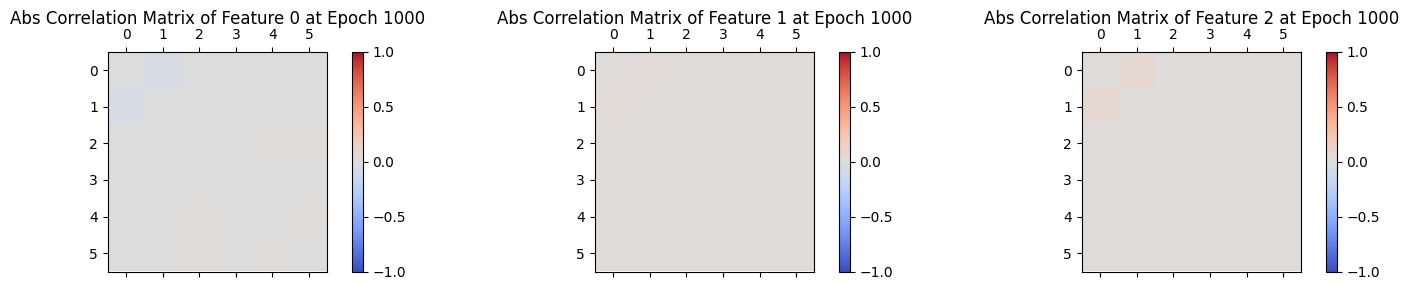

Epoch 2001, MSE Loss: 0.015050560235977173, Correlation Loss: 0.32410773634910583


Epoch 3001, MSE Loss: 0.017651595175266266, Correlation Loss: 0.039902880787849426


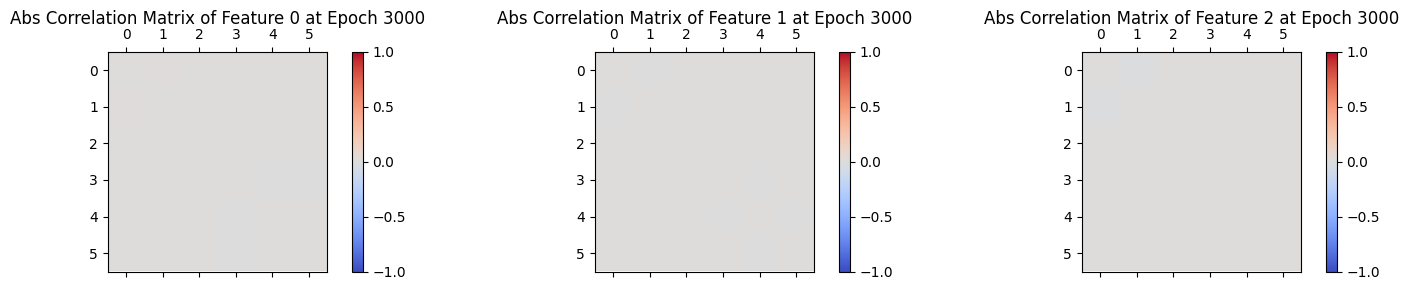

Epoch 4001, MSE Loss: 0.013364898040890694, Correlation Loss: 0.13828222453594208


In [4]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, scale=.1, hidden_dim=3 ):
        super(MLPLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.initialize_weights(scale)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def initialize_weights(self, scale):
        # Initialize weights with scaled He initialization
        nn.init.kaiming_normal_(self.fc1.weight, a=0, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, a=0, mode='fan_in', nonlinearity='relu')

        # Scaling the weights
        self.fc1.weight.data *= scale
        self.fc2.weight.data *= scale

        # If you also want to initialize biases to some value (zero in this example)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)


def corr_matrix(data):
    epsilon = 1e-8
    mean = t.mean(data, dim=0, keepdim=True)
    demeaned_data = data - mean
    covariance = t.mm(demeaned_data.T, demeaned_data) / (data.shape[0] - 1)
    std_dev = t.sqrt(t.diag(covariance) + epsilon).unsqueeze(1)
    correlation = covariance / (std_dev @ std_dev.T)
    correlation -= t.diag(t.diag(correlation))   
    return correlation

# Function to compute correlation of a list of activations
def compute_matrices(*activations, cofunction=corr_matrix):
    #batch, heads, features 
    a = t.stack(activations, dim=1)  #stack across heads
    return [ cofunction(a[:,:,f]) for f in range(a.shape[2]) ] # loop over features

def minimize_matrix_loss(*activations):
    return sum( [ matrix.abs().sum() for i,matrix in enumerate(compute_matrices(*activations))] )  

def plot_matrices(activations, epoch, cols=3):
    matrices = compute_matrices(*activations)
    rows = (len(matrices) + cols - 1) // cols  # Compute the number of rows required
    plt.figure(figsize=(15, 3*rows))
    for i, matrix in enumerate(matrices):
        matrix_np = matrix.detach().numpy()
        plt.subplot(rows, cols, i+1)
        cax = plt.matshow(matrix_np, cmap=plt.cm.coolwarm, vmin=-1, vmax=1, fignum=False)
        plt.colorbar(cax)
        plt.title(f'Abs Correlation Matrix of Feature {i} at Epoch {epoch}', pad=20)
    plt.tight_layout()
    plt.show()

# Generate synthetic data
n_samples  = 1000
n_features = 3
n_heads    = 6

X = t.randn((n_samples, n_features))
coefficients = t.tensor([ float(i) for i in range(1, n_features+1)])
Y = t.sum(coefficients * X, dim=1, keepdim=True)  + 0.1 * t.randn((n_samples, 1))

mlps           = [ MLPLayer(n_features, n_features) if i>0 else MLPLayer(n_features, n_features,scale=1.0) for i in range(n_heads)  ]  

# learning_rates = [0.01 * (i+1) for i in range(n_heads)]
# optimizer      = optim.Adam([{'params': mlp.parameters(), 'lr': lr} for mlp, lr in zip(mlps, learning_rates)])
optimizer      = optim.Adam( [param for mlp in mlps for param in mlp.parameters()], lr=0.01)

# Print optimizer's state_dict to verify learning rates
for i, param_group in enumerate(optimizer.param_groups):
    print(f"MLP {i+1} Learning Rate: {param_group['lr']}")

plot_matrices([ mlp(X) for mlp in mlps], epoch=1)


n_samples_to_select = 100
steps = 5000
for epoch in range(steps):


    indices = t.randperm(n_samples)[:n_samples_to_select]
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    activations = [ mlp(sampled_X) for mlp in mlps]
    regularization_loss = minimize_matrix_loss(*activations)


        # Check for NaN in activations
    if any(t.isnan(act).any() for act in activations):
        print("NaN found in activations")
        break

    # batch, heads, features 
    stacked_activations = t.stack(activations, dim=1) 
    mse_losses = nn.MSELoss()(   t.sum(stacked_activations, dim=(1,2)).unsqueeze(1) ,  sampled_Y) 
    
    
    # l1_reg_loss = t.sum(t.stack([ t.abs(param).sum() for mlp in mlps for param in mlp.parameters() ]))
    # l1_reg_loss = .01*t.sum(t.abs(stacked_activations))
    # l2_reg_loss = .01*t.sum( stacked_activations ** 2)

    combined_loss = mse_losses + regularization_loss #+ l1_reg_loss

    if (t.isnan(mse_losses).any()) :
        print("mse_losses")
        break

    if (t.isnan(regularization_loss).any()) :
        print("regularization_loss")
        break

    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()


    if (epoch) % 1000 == 0:
        print(f"Epoch {epoch+1}, MSE Loss: {mse_losses.item()}, Correlation Loss: {regularization_loss.item()}")
        plot_matrices(activations, epoch=epoch)


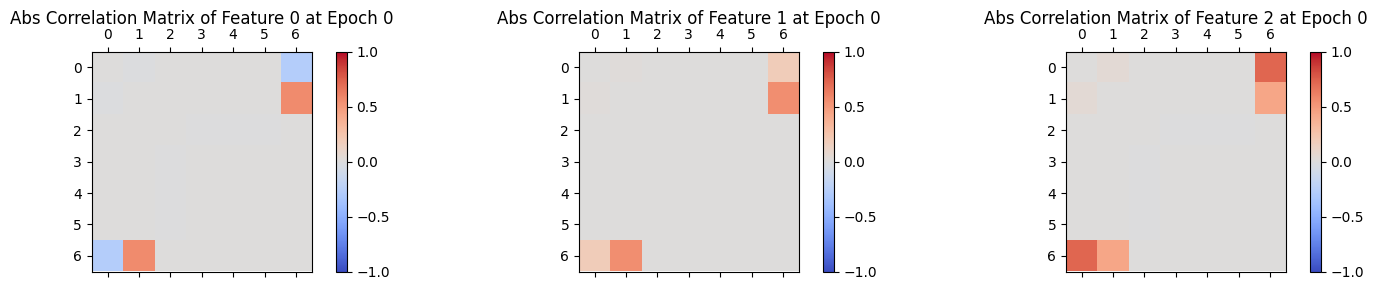

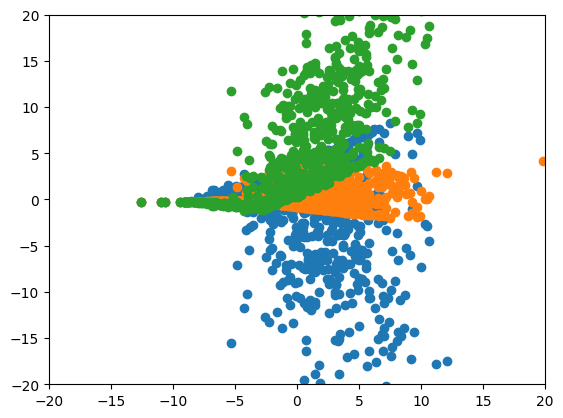

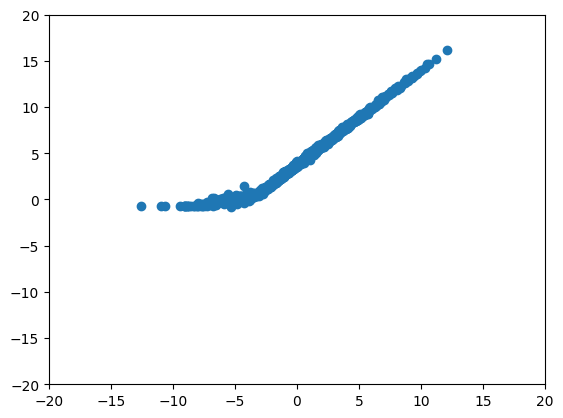

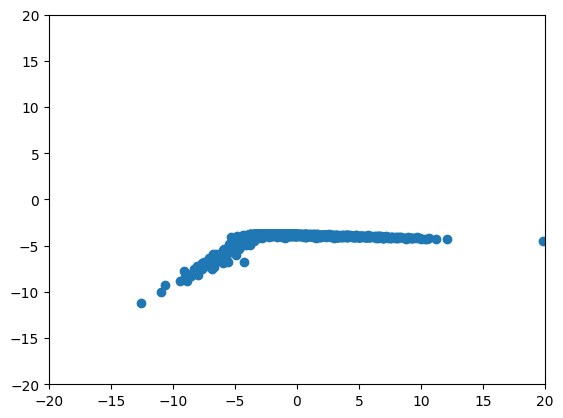

In [5]:
# x = t.tensor( [[(i-50)/100.0,(i-50)/100.0] for i in range(100) ] ).squeeze(0)
activations = [ mlp(X) for mlp in mlps]

t.set_printoptions(precision=2, sci_mode=False)

all_activations = t.stack(activations, dim=1) 

yc = t.stack([ Y for i in range(all_activations.shape[2])], dim=1).squeeze()

act_y = activations.copy()
act_y.append(yc)

plot_matrices(act_y, epoch=0)

bounds = 20

# batch, heads, features 
plt.scatter(Y, all_activations[:,0,0].detach().cpu().numpy() )
plt.scatter(Y, all_activations[:,0,1].detach().cpu().numpy() )
plt.scatter(Y, all_activations[:,0,2].detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
plt.scatter(Y, t.sum( all_activations[:,0,:], dim=1).unsqueeze(1).detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
plt.scatter(Y, t.sum( all_activations[:,1:,:], dim=(1,2) ).unsqueeze(1).detach().cpu().numpy() )
plt.xlim(-bounds, bounds)  # Set bounds for x-axis
plt.ylim(-bounds, bounds)  # Set bounds for y-axis
plt.show()
# plt.scatter(Y, X[:,0] )
# plt.scatter(Y, X[:,1] )
# plt.scatter(Y, X[:,2] )
# plt.xlim(-bounds, bounds)  # Set bounds for x-axis
# plt.ylim(-bounds, bounds)  # Set bounds for y-axis
# plt.show()



In [10]:
plot_predictions_vs_train( t.sum(t.stack(activations,dim=1), dim=(1,2)).unsqueeze(1), Y)


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


torch.Size([1000, 3])
(1000, 1)
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([1000, 3])


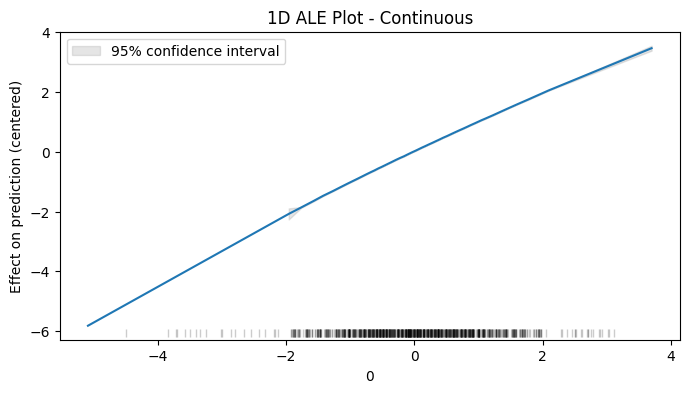

In [33]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import r2_score
from PyALE import ale
import pandas as pd

# Create a DataFrame
features=['0', '1', '2']
df = pd.DataFrame(X.detach().cpu().numpy(), columns=features)

# # Now df is a Pandas DataFrame with the data from tensor
# print(df[features])

class SKlearnModel(BaseEstimator):
    def __init__(self) :
        return

    def fit(self, X, y):
        # do nothing
        return

    def predict(self, X):
        X = t.tensor(X.to_numpy(), dtype=t.float32)
        print(X.shape)
        activations = [ mlp(X) for mlp in mlps]     
        all_activations = t.stack(activations, dim=1) 
        outputs = t.sum(all_activations, dim=(1,2)).unsqueeze(1) 
        return outputs.detach().cpu().numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Usage:
model = SKlearnModel()


y = model.predict(df)
print(y.shape)
print(X.shape)



ale_eff = ale(
    X=df[features], model=model, feature=['0'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=model, feature=['1'], grid_size=50, include_CI=True, C=0.95
)
ale_eff = ale(
    X=df[features], model=model, feature=['2'], grid_size=50, include_CI=True, C=0.95
)


